In [1]:
import numpy as np
from matplotlib import pyplot as plt

from lib import Loads

In [2]:
solid1 = Loads.execute("data/entrada.xls")

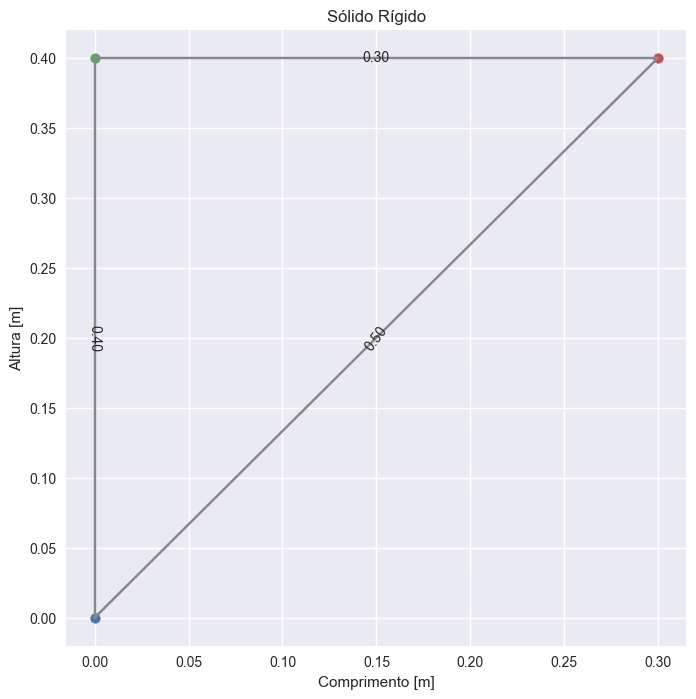

In [3]:
plt.style.use('seaborn-v0_8')
plt.figure(figsize=(8, 8))

plt.title("Sólido Rígido")
plt.xlabel("Comprimento [m]")
plt.ylabel("Altura [m]")
solid1.plot()
plt.show()

In [5]:
mask_ = np.array([node.displacement for node in solid1.nodes]).flatten()
mask = np.bitwise_not(mask_)
mask

array([False,  True, False, False,  True,  True])

In [4]:
K = solid1.rigidity
K[mask][:, mask]

[[ 3.0240e+07  4.0320e+07  0.0000e+00  0.0000e+00 -3.0240e+07 -4.0320e+07]
 [ 4.0320e+07  1.5876e+08  0.0000e+00 -1.0500e+08 -4.0320e+07 -5.3760e+07]
 [ 0.0000e+00  0.0000e+00  1.4000e+08  0.0000e+00 -1.4000e+08  0.0000e+00]
 [ 0.0000e+00 -1.0500e+08  0.0000e+00  1.0500e+08  0.0000e+00  0.0000e+00]
 [-3.0240e+07 -4.0320e+07 -1.4000e+08  0.0000e+00  1.7024e+08  4.0320e+07]
 [-4.0320e+07 -5.3760e+07  0.0000e+00  0.0000e+00  4.0320e+07  5.3760e+07]]


[30240000.0, 158760000.0, 140000000.0, 105000000.0, 170240000.0, 53760000.0]

In [7]:
F = []

for node in solid1.nodes:
    r = node.get_resultant_force()

    F.append(r.x)
    F.append(r.y)

F = np.array(F)
F[mask]

array([   0.,    0.,    0.,    0.,  150., -100.])

In [9]:
from lib import GaussSeidel_Solver

GaussSeidel_Solver.solve(K[mask][:, mask], F[mask], 1e-3)

c:\Users\Lucius\Documents\Insper\Disciplinas\TransCal_MecSol\APS\APS #4\lib\solver.py:20: RuntimeWarning: invalid value encountered in double_scalars
  err = np.abs((xi - x[i]) / xi)


array([-9.51894727e-07,  1.60667089e-06, -4.01701694e-06])